# Load Packages

In [75]:

%load_ext autoreload
%autoreload 2

import sys
from os.path import join
from tqdm.auto import tqdm
import joblib
import torch
sys.path.append("../../")

from src.file_manager.load_data import load_split_dict
from src.file_processing.processing_predictions import load_prediction_df_dict, save_pi_df_dict
from src.file_processing.processing_predictions import load_pi_df_dict
from src.file_manager.save_load_scaler import load_scaler
from src.pi_methods.knn import knn_prediction_interval
from src.pi_methods.weighted import weighted_prediction_interval
from src.pi_methods.cond_gaussian import cond_gauss_prediction_interval
from src.pi_methods.gaussian_copula import gauss_copula_prediction_interval
from src.pi_methods.conformal_prediction import conformal_prediction_interval
from src.evaluation.investigate_re_pe_distribution import investigate_re_n_pe_for_all_seeds, investigate_re_n_pe
from src.misc import create_folder
from ue_pi_dicts import ue_dict
# from seed_file import seed
from src.evaluation.knn_ablation import knn_ablation, display_knn_ablation

seed = 2023
data_label = "physionet"
batch_size = 64

# File paths
fp_notebooks_folder = "../"
fp_project_folder = join(fp_notebooks_folder, "../")
fp_processed_data_folder = join(fp_project_folder, "processed_data")
fp_output_data_folder = join(fp_processed_data_folder, "physionet")
fp_checkpoint_folder = join(fp_project_folder, "checkpoints")
fp_project_checkpoints = join(fp_checkpoint_folder, data_label)
fp_tuning = join(fp_project_checkpoints, "tuning")
fp_models = join(fp_project_checkpoints, "models")
fp_predictions = join(fp_project_checkpoints, "predictions")
fp_pi_predictions = join(fp_project_checkpoints, "pi_predictions")
fp_ablation_folder = join(fp_project_checkpoints, "knn_ablation")

pred_file_names =  ["rue", "gpr", "infernoise", "der", "bnn"]
fp_cur_predictions_folder = join(fp_predictions, str(seed))
fp_cur_ablation_folder = join(fp_ablation_folder, str(seed))
create_folder(fp_cur_ablation_folder)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Data

In [35]:
split_dict = load_split_dict(fp_output_data_folder)
scaler = load_scaler(join(fp_output_data_folder, "scaler.pickle"))
pred_df_dict = load_prediction_df_dict(
    split_dict, fp_cur_predictions_folder, pred_file_names=pred_file_names) 

  0%|          | 0/3 [00:00<?, ?it/s]

In [55]:
def get_k_list(start, end, mutiplier):
    k_list, k = [], start
    while k < end:
        k_list.append(k)
        k = k*mutiplier
    return k_list

k_list = get_k_list(start=2, end=len(pred_df_dict["t+1"]["valid_df"]), mutiplier=2)
k_list

[2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]

# KNN Ablation
- A very small `k` value causes KNN to be highly susceptible to outliers in its neighbours resulting in poorer PI performance.
- A large k value causes KNN to consider points that are highly dissimilar to the query point in the reconstruction error space, also resulting in suboptimal PI performance

In [79]:
knn_ablation_df = knn_ablation(
    pred_df_dict=pred_df_dict, k_list=k_list, 
    ue_dict=ue_dict, 
    fp_cur_ablation_folder=fp_cur_ablation_folder,
    scaler=scaler, split_dict=split_dict, seed=seed
)
knn_ablation_df

  0%|          | 0/10 [00:00<?, ?it/s]

,2,4,8,16,32,64,128,256,512,1024
Time Horizon,,,,,,,,,,
t+1,3.304839,3.304839,3.304839,3.304839,3.304839,0.482268,0.431301,0.492112,0.511528,0.350638
t+2,3.339899,3.339899,3.339899,3.339899,3.339899,0.605376,0.582365,0.609348,0.630820,0.437536
t+3,3.363679,3.363679,3.363679,3.363679,3.363679,0.636184,0.616888,0.675856,0.806692,0.560096
Mean,3.336139,3.336139,3.336139,3.336139,3.336139,0.574609,0.543518,0.592439,0.649680,0.449423


# KNN Ablation Line Graph

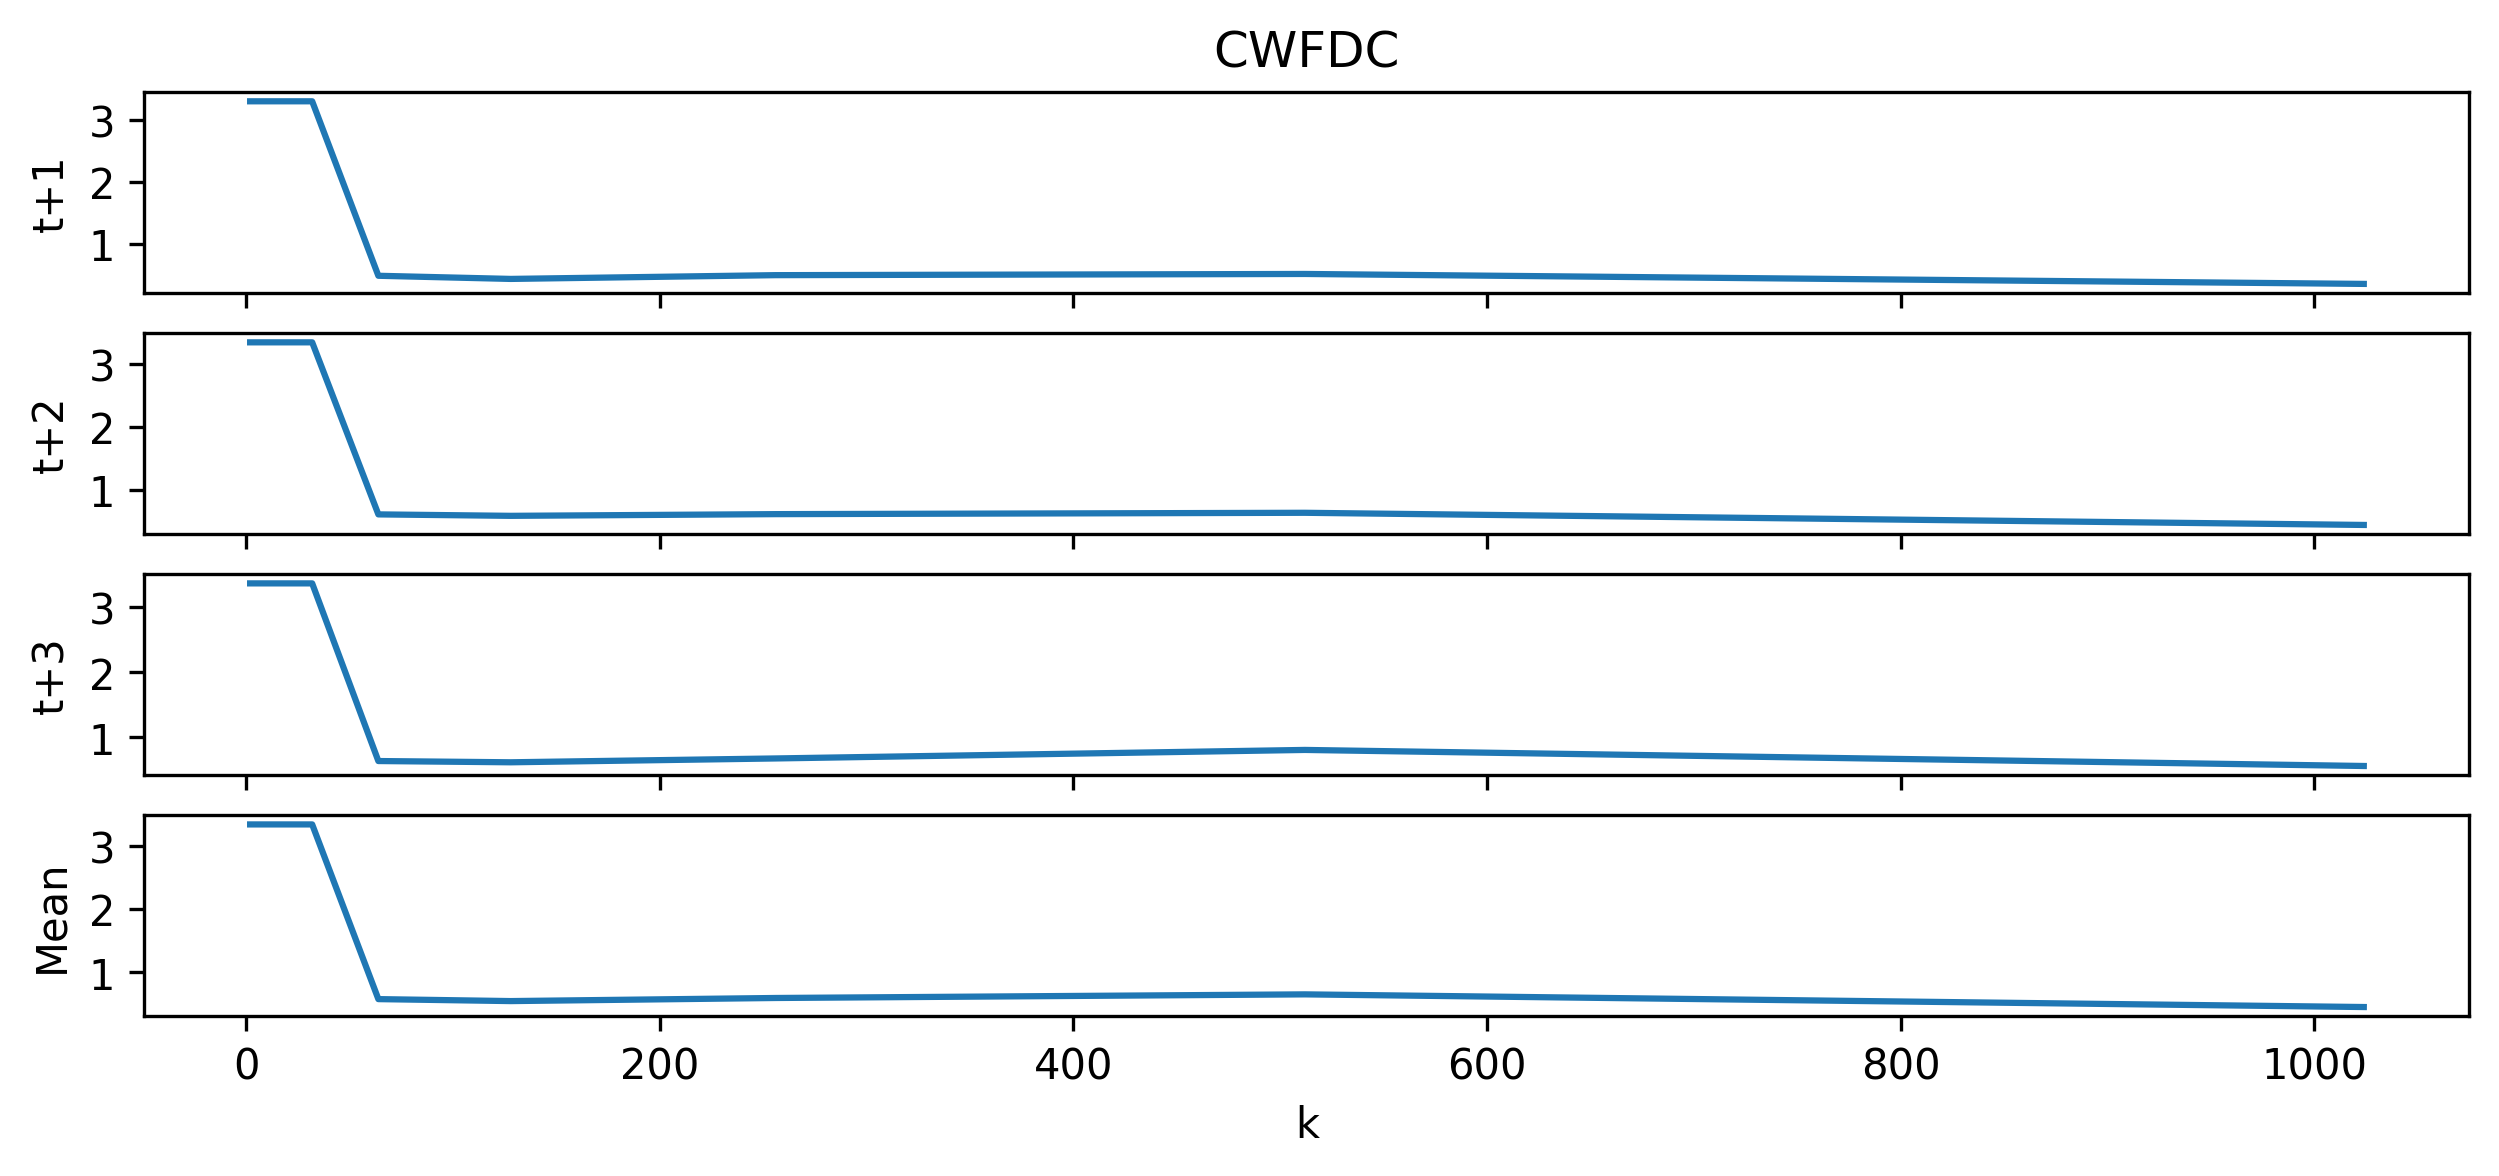

In [80]:
display_knn_ablation(knn_ablation_df)